In [124]:
import pandas as pd
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


In [70]:
df_temp_out = pd.read_csv('outdoor_temperature.csv')  
df_temp_in = pd.read_csv('indoor_temperature.csv')  
df_heat = pd.read_csv('heating_consumption.csv')  

df_combined = pd.concat([df_temp_out, df_temp_in, df_heat], axis=1)  
date_range = pd.date_range(start='2021-01-01', end='2022-12-28', freq='D')
df_combined['date'] = date_range
print(df_combined)

     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0       0.9     1.4     1.6     0.8    -0.4    -1.1    -1.2      -0.7    -0.7   
1       0.8     0.9     0.9     1.1     1.3     1.3     0.1      -0.6     1.9   
2       0.5     0.2     0.1     0.6     0.3    -0.4    -0.4       0.1     0.8   
3       1.9     1.7     1.3     1.5     1.5     1.3     1.0       0.9     1.1   
4       1.4     1.5     1.5     1.5     1.4     1.5     1.5       1.4     1.7   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
722     7.1     7.2     7.6    10.5    11.7     8.5     7.7       8.0    11.0   
723     8.1     7.8     6.9     7.0     5.8     7.8     6.5       7.5     9.1   
724    10.9    11.0    10.7    10.9    10.9    10.6    10.5      10.7    11.0   
725     6.5     6.9     6.3     5.8     4.9     4.8     4.0       5.1     7.3   
726     9.3     8.9     8.7     8.7     9.2     9.1    10.3       9.1     9.8   

     2.3000  ...  0.0000.15

In [72]:
df_no_heating = df_combined[df_combined.iloc[:, -25:-1].sum(axis=1) == 0]  
df_heating = df_combined[df_combined.iloc[:, -25:-1].sum(axis=1) != 0]      

#print(df_no_heating)
df_heating = df_heating.reset_index(drop=True)

print(df_heating)


     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0       0.5     0.2     0.1     0.6     0.3    -0.4    -0.4       0.1     0.8   
1       1.9     1.7     1.3     1.5     1.5     1.3     1.0       0.9     1.1   
2       1.4     1.5     1.5     1.5     1.4     1.5     1.5       1.4     1.7   
3      -3.0    -3.0    -3.4    -3.7    -4.7    -4.6    -4.6      -4.6    -3.0   
4      -3.6    -4.2    -3.8    -4.8    -4.8    -5.0    -5.1      -4.9    -2.4   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
240    12.1    12.1    12.3    12.3    12.4    12.2    12.3      12.4    12.8   
241    12.6    12.2    12.0    12.6    12.7    12.6    12.9      13.1    13.3   
242    12.3    11.9    11.9    11.1    10.8    10.5    10.3      10.5    11.0   
243    10.8    10.6    11.1     9.3     9.0     7.9     8.6       9.0    10.6   
244    12.2    10.8    10.6    10.2     9.5     9.3     8.9       8.9    10.8   

     2.3000  ...  0.0000.15

In [73]:
heating_indices = df_heating.index
#print(heating_indices)
df_temp_out_heating = df_temp_out.iloc[heating_indices]
df_temp_in_heating = df_temp_in.iloc[heating_indices]
df_heat_heating = df_heat.iloc[heating_indices]

#print(df_temp_out_heating)
#print(df_temp_in_heating)
#print(df_heat_heating)

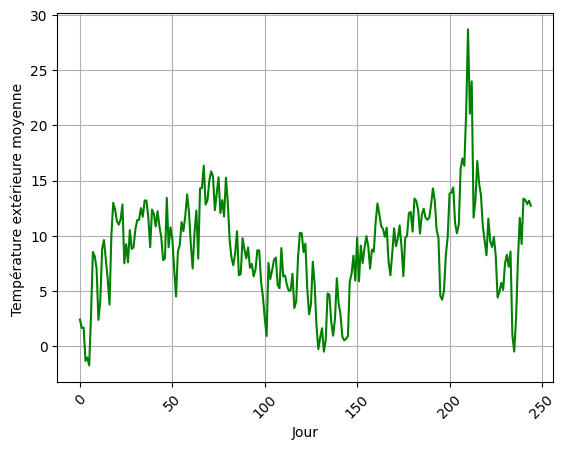

In [111]:
external_temp_columns = df_heating.columns[:24]
heating_days_avg_temp = df_heating[external_temp_columns].mean(axis=1)
plt.plot(df_heating.index, heating_days_avg_temp, linestyle='-', color='g')
plt.xlabel('Jour')
plt.ylabel('Température extérieure moyenne ')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

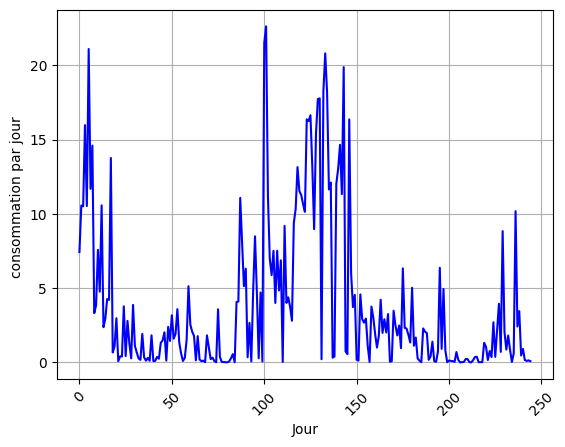

In [74]:

sums_last_24 = df_heating.iloc[:, -24:-1].sum(axis=1)

plt.plot(df_heating.index, sums_last_24, linestyle='-', color='b')
plt.xlabel('Jour')
plt.ylabel('consommation par jour ')
plt.grid(True)
plt.xticks(rotation=45) 
plt.show()


In [75]:
def normalize_data(data):
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data.values.reshape((data.shape[0], data.shape[1], 1)))
    return pd.DataFrame(data_normalized.reshape(data_normalized.shape[0], data_normalized.shape[1]), columns=data.columns)


In [76]:

def apply_kmeans(data,data_normalized, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data_normalized['cluster'] = kmeans.fit_predict(data_normalized)
    data['cluster']=data_normalized['cluster']
    return kmeans, data


In [113]:
df_heating2=df_heating.drop(columns=["date"])
df_normalized = normalize_data(df_heating2)

kmeans, data_normalized_with_cluster = apply_kmeans(df_heating2,df_normalized, 4)

df_heating2=df_heating.copy()
df_heating["cluster"]=data_normalized_with_cluster["cluster"]
df_heat_heating.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]
df_temp_in_heating.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]
df_temp_out_heating.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]


In [114]:
def compute_cluster_means(data_normalized, cluster_assignments, column_index):
    cluster_means = {}

    for cluster_id in np.unique(cluster_assignments):
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        cluster_means[cluster_id] = cluster_data.mean(axis=0)  

    return cluster_means


In [125]:
def plot_clusters_single_variable(data_normalized, cluster_assignments, column_index, y_label="Valeur", num_labels=10):
    cluster_means = compute_cluster_means(data_normalized, cluster_assignments, column_index)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    all_values = []
    for cluster_id, cluster_center in cluster_means.items():
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        all_values.extend(cluster_data.values.flatten())  
    y_min = np.min(all_values)
    y_max = np.max(all_values)

    for cluster_id, cluster_center in cluster_means.items():
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]

        for idx, row in cluster_data.iterrows():
            axes[cluster_id // 2, cluster_id % 2].plot(range(24), row, color='gray', alpha=0.5)
        
        axes[cluster_id // 2, cluster_id % 2].plot(range(24), cluster_center, color='red', linewidth=3, label=f"Centre du cluster {cluster_id}")
        
        axes[cluster_id // 2, cluster_id % 2].set_title(f"Séries temporelles du Cluster {cluster_id}")
        axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heures")
        axes[cluster_id // 2, cluster_id % 2].set_ylabel(y_label)
        
        axes[cluster_id // 2, cluster_id % 2].set_ylim([y_min, y_max])
        axes[cluster_id // 2, cluster_id % 2].grid(True)

    plt.tight_layout()
    plt.show()

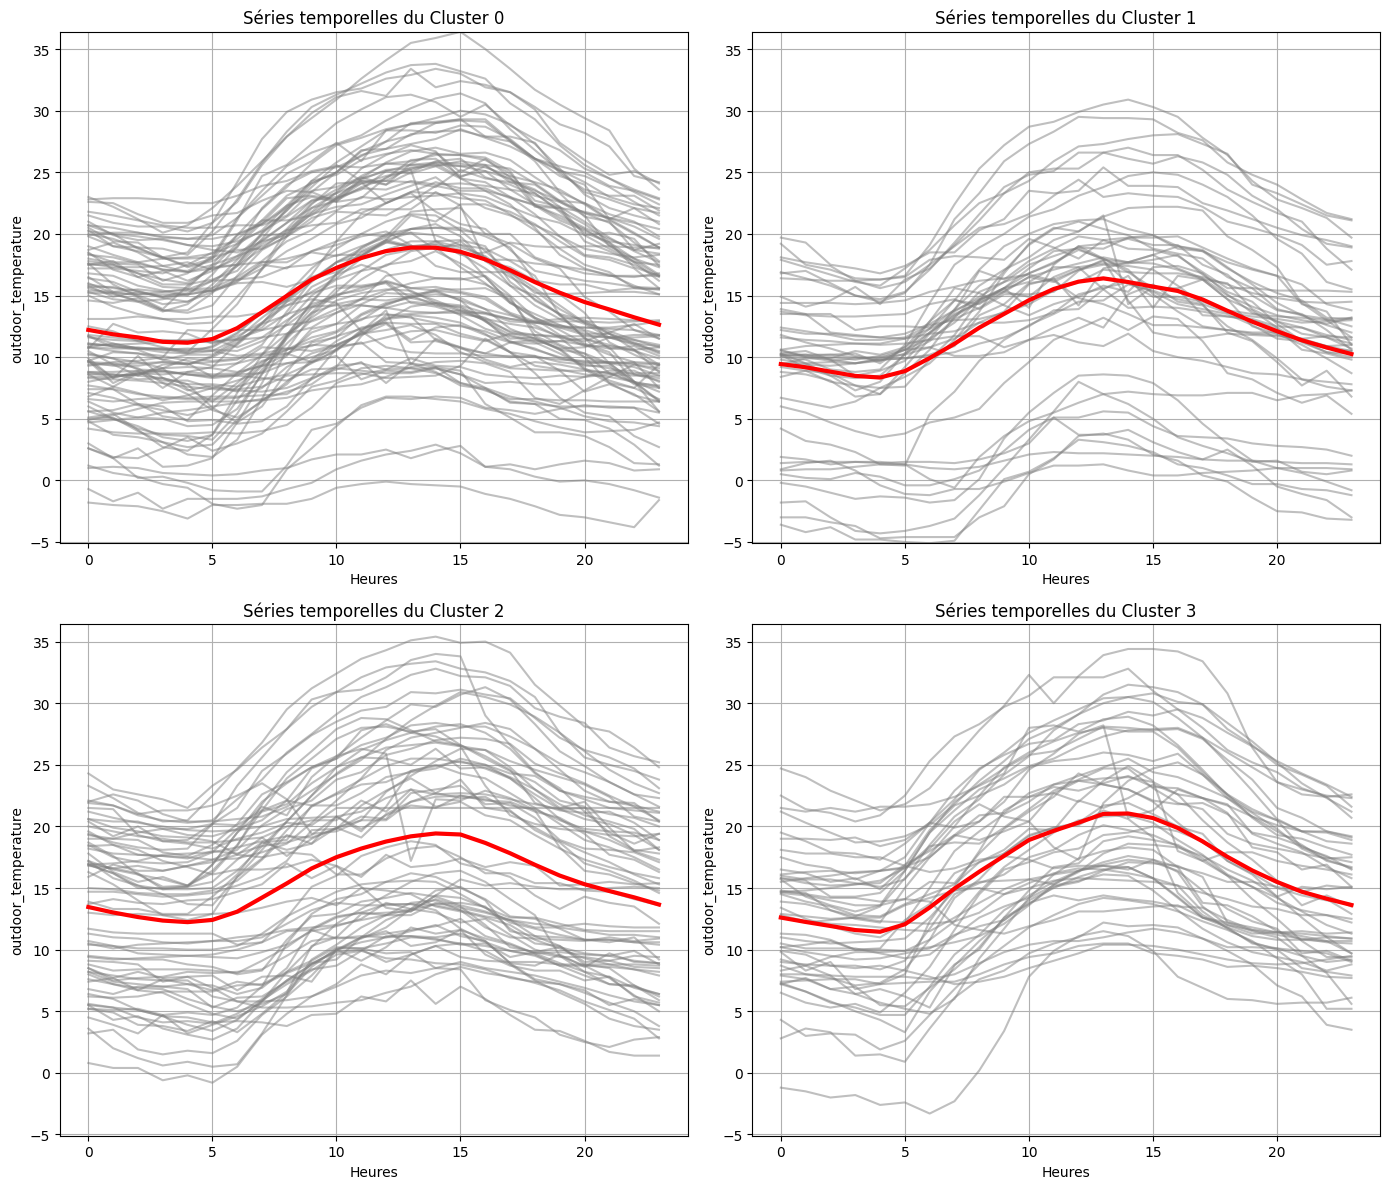

In [126]:
plot_clusters_single_variable(df_temp_out_heating, df_temp_out_heating["cluster"], column_index=0, y_label="outdoor_temperature")


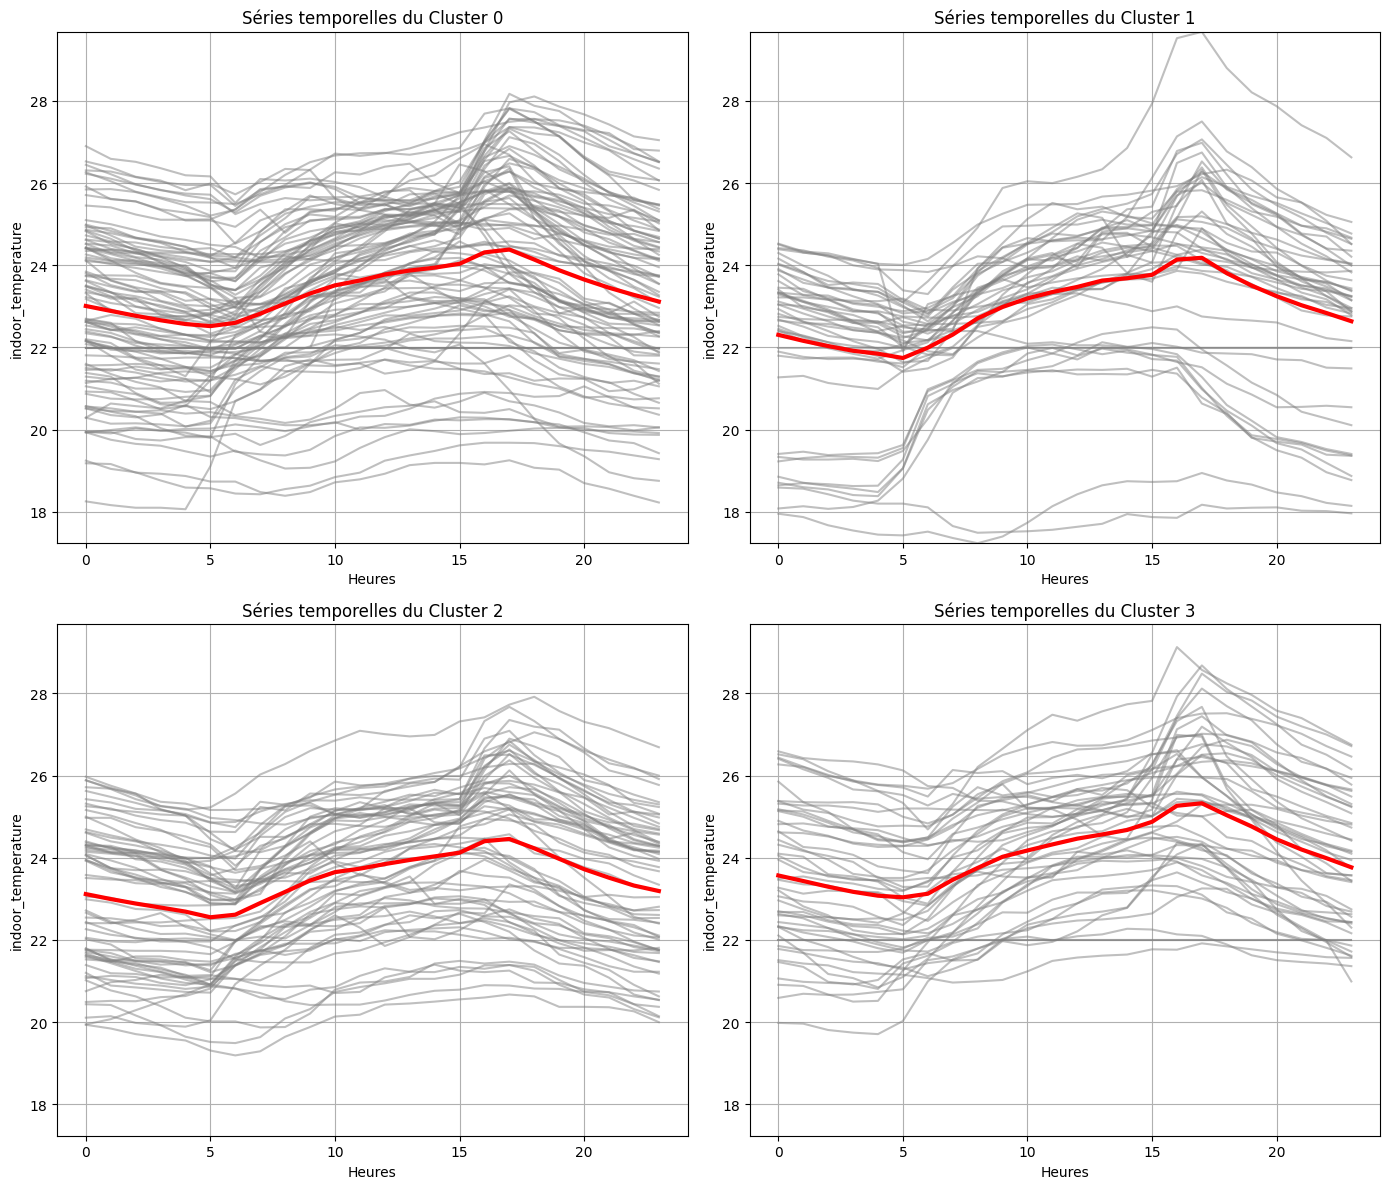

In [117]:
plot_clusters_single_variable(df_temp_in_heating, df_temp_in_heating["cluster"], column_index=0, y_label="indoor_temperature")



In [120]:
print(df_heating2)

     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0       0.5     0.2     0.1     0.6     0.3    -0.4    -0.4       0.1     0.8   
1       1.9     1.7     1.3     1.5     1.5     1.3     1.0       0.9     1.1   
2       1.4     1.5     1.5     1.5     1.4     1.5     1.5       1.4     1.7   
3      -3.0    -3.0    -3.4    -3.7    -4.7    -4.6    -4.6      -4.6    -3.0   
4      -3.6    -4.2    -3.8    -4.8    -4.8    -5.0    -5.1      -4.9    -2.4   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
240    12.1    12.1    12.3    12.3    12.4    12.2    12.3      12.4    12.8   
241    12.6    12.2    12.0    12.6    12.7    12.6    12.9      13.1    13.3   
242    12.3    11.9    11.9    11.1    10.8    10.5    10.3      10.5    11.0   
243    10.8    10.6    11.1     9.3     9.0     7.9     8.6       9.0    10.6   
244    12.2    10.8    10.6    10.2     9.5     9.3     8.9       8.9    10.8   

     2.3000  ...  0.0000.16

In [123]:

labels = df_heating['cluster'] 
df_heating2=df_heating2.drop(columns=["date"])
sil_score = silhouette_score(df_heating2, labels, metric='euclidean')
db_score = davies_bouldin_score(df_heating2, labels)

print(f"Davies-Bouldin Index: {db_score}")
print(f"Silhouette Score: {sil_score}")


Davies-Bouldin Index: 1.1400466536729257
Silhouette Score: 0.2745732321305846


In [109]:
heating_dict = {}

for idx, row in df_heating.iterrows():
    heating_dict[idx] = {
        'date': row['date'],
        'text': row.iloc[:24].values.tolist(),
        'tint': row.iloc[24:48].values.tolist(),
        'heating': row.iloc[48:-1].values.tolist(),
        'label': row['cluster'] 
    }



In [110]:
heating_df = pd.DataFrame(heating_dict)

print(heating_df)

                                                       0    \
date                                   2021-01-03 00:00:00   
text     [0.5, 0.2, 0.1, 0.6, 0.3, -0.4, -0.4, 0.1, 0.8...   
tint     [18.0818, 18.1364, 18.0727, 18.1182, 18.2727, ...   
heating  [0.0, 0.0, 0.0, 0.0, 0.0, 0.598, 0.926, 2.525,...   
label                                                    1   

                                                       1    \
date                                   2021-01-04 00:00:00   
text     [1.9, 1.7, 1.3, 1.5, 1.5, 1.3, 1.0, 0.9, 1.1, ...   
tint     [19.3364, 19.2727, 19.2727, 19.2909, 19.2364, ...   
heating  [0.0, 0.0, 0.0, 0.0, 0.0, 0.189, 0.694, 2.227,...   
label                                                    1   

                                                       2    \
date                                   2021-01-05 00:00:00   
text     [1.4, 1.5, 1.5, 1.5, 1.4, 1.5, 1.5, 1.4, 1.7, ...   
tint     [19.2273, 19.3091, 19.3545, 19.3364, 19.3182, ...   
heatin